**A.** Préliminaires

**A.1.** Imports :

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as ls
from os.path import join
import time
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn   
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import copy
import pickle
import time


**A.2.** Montage du répertoire contenant les sources et le dataset :

In [66]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**A.3.** imports locaux 

In [67]:
# os.chdir('/content/drive/MyDrive/sameCamera/src_real')

In [1]:
import sys
sys.path.insert(1, '/home/mdso/lepetitp/ppc/WEBCAMS/src/samecamera/training_samecamera')
sys.path.insert(1, '/home/mdso/lepetitp/ppc/WEBCAMS/src/images2sqlite')

from importlib import reload
import utile_ds_tr_series
from utile_ds_tr_series import *
from utile_trainReId import *
from utile_architectures import *
import utile_online_clustering

ModuleNotFoundError: No module named 'torch'

**A.4** Copie des répertoires et chemin

In [68]:
dir_train = '/root/ds_sameCamera/ds_sameCamera_train'
dir_val = '/root/ds_sameCamera/ds_sameCamera_val'
dir_test = '/root/ds_sameCamera/ds_sameCamera_test'
dir_series = '/root/ds_sameCamera/ds_sameCamera_series'

In [69]:
# ! tar -cf ../ds_sameCamera/ds_sameCamera_train.tar   ../ds_sameCamera/ds_sameCamera_train
# ! tar -cf ../ds_sameCamera/ds_sameCamera_val.tar   ../ds_sameCamera/ds_sameCamera_val
# ! tar -cf ../ds_sameCamera/ds_sameCamera_test.tar   ../ds_sameCamera/ds_sameCamera_test

if not os.path.isdir('/root/ds_sameCamera/ds_sameCamera_test'):
  # !cp -r ../ds_sameCamera/ds_sameCamera_train.tar	/root/
  # !tar -xf  /root/ds_sameCamera_train.tar  -C /root/

  # !cp -r ../ds_sameCamera/ds_sameCamera_val.tar	/root/
  # !tar -xf  /root/ds_sameCamera_val.tar  -C /root

  !cp -r ../ds_sameCamera/ds_sameCamera_test.tar	/root/
  !tar -xf  /root/ds_sameCamera_test.tar  -C /root


  !cp -r ../ds_sameCamera/ds_sameCamera_test.tar	/root/
  !tar -xf  /root/ds_sameCamera_series.tar  -C /root


In [70]:
print(len(ls(dir_test)))

print(len(set([c.split('_')[0] for c in ls(dir_test)])))

print(6*189)

189
91
1134


**E.** Test sur les séquences courtes de dir_test

**E.1** Construction du jeu de test, viz

In [71]:
import importlib
import utile_trainReId
importlib.reload(utile_trainReId)
from utile_trainReId import *
from utile_ds_tr_test import *
from utile_architectures import *


In [111]:
# Instance of transforms:
size_in = 256+32
size_out = 256-32
tr_test = tr_ReID_test(size_in, size_out)


# Instance of Dataset_ReID
Ktest_viz = 4
Ktest = 10
Stest = 6
batch_size_test = 3

Ntest = batch_size_test * Stest

kwargs_test = {'size_in': size_in,
                'size_out': size_out,
                'marginsup':0.1,
                'margininf':0.1,
                'cropped_prop':0.7,
                'zoom':0
                }

  
ds_viz_test = Dataset_ReID_test(dir_test, tr_test, Ktest_viz, Stest, **kwargs_test) 

dl_viz_test = torch.utils.data.DataLoader(ds_viz_test, 
                                          batch_size=batch_size_test, 
                                          shuffle=False, 
                                          num_workers=2)

ds_test = Dataset_ReID_test(dir_test, tr_test, Ktest, Stest, **kwargs_test)  
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size_test, 
                                           shuffle=False, num_workers=2)




In [112]:
it = iter(dl_viz_test)
imgs, labels, codes = next(it)
print(imgs.shape)

torch.Size([3, 24, 3, 224, 224])


In [113]:
def imshow(inp, title=None):
    #Imshow for Tensor
    plt.figure(figsize = (20,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


## Make a grid from batch
imgs = imgs.reshape(batch_size_test * Ktest_viz * Stest, 3, size_out, size_out)
out0 = torchvision.utils.make_grid(imgs)


print(labels)
print(imgs.shape)
imshow(out0)


Output hidden; open in https://colab.research.google.com to view.

In [75]:
imgs.shape

torch.Size([72, 3, 224, 224])

In [76]:
print(codes[0]['angle'])
print(codes[1]['angle'])

print(codes[0]['perspective'][1])
print(codes[1]['perspective'][1])

print(codes[0]['cropping'])
print(codes[1]['cropping'])

print(codes[0]['flip'])
print(codes[1]['flip'])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[15., 15., 15., 15.],
        [15., 15., 15., 15.],
        [15., 15., 15., 15.]])
[[tensor([0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0.], dtype=torch.float64)], [tensor([288., 288., 288.], dtype=torch.float64), tensor([0., 0., 0.], dtype=torch.float64)], [tensor([288., 288., 288.], dtype=torch.float64), tensor([288., 288., 288.], dtype=torch.float64)], [tensor([0., 0., 0.], dtype=torch.float64), tensor([288., 288., 288.], dtype=torch.float64)]]
[[tensor([0., 0., 0.], dtype=torch.float64), tensor([0., 0., 0.], dtype=torch.float64)], [tensor([288., 288., 288.], dtype=torch.float64), tensor([0., 0., 0.], dtype=torch.float64)], [tensor([288., 288., 288.], dtype=torch.float64), tensor([288., 288., 288.], dtype=torch.float64)], [tensor([0., 0., 0.], dtype=torch.float64), tensor([288., 288., 288.], dtype=torch.float64)]]
[tensor([202, 202, 202]), tensor([43, 43, 43]), tensor([43, 43, 43])]
[tenso

**E.3** Test: justesse des centres

In [77]:
! ls ../models

modified_resnet50_bestacc_checkpoint
resnet50_100ep_checkpoint
resnet50_200ep_checkpoint
resnet50_eraser_final_checkpoint
resnet50_erazer_checkpoint
resnet50_lastcheckpoint
resnet50_nl_1gpu_bm.checkpoint
resnet50_nl_1gpu_le.checkpoint
resnet50_nl_daug2_sched100_1gpu_bm.checkpoint
resnet50_nl_daug2_sched100_1gpu_le.checkpoint
results


In [114]:
#%% Test:
archi = 'resnet50_nl'

# chargement du modèle:
if archi == 'resnet50':
    num_latentdims = 100
    model = torchvision.models.resnet50(progress=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_latentdims)
    PATH_final_checkpoint = r"../models/resnet50_eraser_final_checkpoint" #r"../models/resnet50_200ep_checkpoint"-> lastepoq ou r"../models/resnet50_100ep_checkpoint" -> best epoch
    # PATH_bestacc_checkpoint = r"../models/resnet50_checkpoint" #r"../models/resnet50_lastcheckpoint"

    model.load_state_dict(torch.load(PATH_final_checkpoint)['model_state_dict'])
   

if archi == 'resnet50_nl':

    PATH_bm1 = "../models/" + archi + "_1gpu_bm.checkpoint"
    PATH_le1 = "../models/" + archi + "_1gpu_le.checkpoint"
    PATH_bm2 = "../models/" + archi + "_daug2_sched100_1gpu_bm.checkpoint"
    PATH_le2 = "../models/" + archi + "_daug2_sched100_1gpu_le.checkpoint"
    PATH_checkpoint = PATH_bm2

    gem_pool = True
    # resnet = torchvision.models.resnet50(progress=True)
    # torch.save(resnet.state_dict(), path_ResNet50_weights)
    last_stride = 1 
    model_path = ''
    model_name = 'resnet50_nl' 
    gem_pool = 'on'
    pretrain_choice = None
    num_latentdims = 2048
    model = Baseline(num_latentdims, last_stride, 
                      None, model_name,
                      gem_pool, None)
    checkpoint = torch.load(PATH_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])




model = model.cuda()
model.eval()

manualSeed = 0
torch.manual_seed(manualSeed)


running_distToCenters = []
global_feat = []
global_labels = []
with torch.no_grad():
    for i, (images, labels, _)  in enumerate(dl_test):
        bs, bSK, ch, size, _ = images.shape
        bN = bs * bSK // Ktest 
        images = images.view(bs*bSK, ch, size, size).cuda()
        labels = labels.detach() #.reshape(bs*bSK)

        feat = model(images).detach()



        # centers = feat.view(bs*Stest, Ktest, num_latentdims).mean(dim=1)
        # distToCenters = euclidean_dist(feat, centers)
        # prev = torch.min(distToCenters, dim=1)[1]
        # obs = torch.arange(bN).repeat_interleave(Ktest).cuda()
        # acc = float((prev == obs).sum())/float(len(prev))
        # print("acc")
        # print(acc)

        # czech means : 
        distToCenters = czech_distToCenters(
                            feat.view(bN, Ktest, num_latentdims))

        # prev = torch.min(distToCenters.view(Ktest*bN,bN), dim=1)[1]
        # obs = torch.arange(bN).repeat_interleave(Ktest).cuda()
        # acc = float((prev == obs).sum())/float(len(prev))
        # print("czech acc")
        # print(acc)


        feat = feat.reshape(bs, Stest, Ktest, num_latentdims).cpu()            
        global_feat.append(feat)
        global_labels.append(labels)    
        running_distToCenters.append(distToCenters) 

        del images, labels
        del feat
        torch.cuda.empty_cache()            

catglobal_feat = torch.cat(global_feat, dim=0) #.reshape((Ntest*Ktest,num_latentdims))
catglobal_labels = torch.cat(global_labels, dim=0)



Generalized Mean Pooling


In [115]:
# epoch_distToCenters = torch.stack(running_distToCenters[:-1])
AP = get_AP(epoch_distToCenters)
print(AP)


0.9934881188178126


In [116]:
ds_size = len(ds_test)
# Global:
centers = catglobal_feat[:,:,:,:].mean(dim=2)
distToCenters = euclidean_dist(catglobal_feat.view(ds_size*Stest*Ktest,
                                                   num_latentdims),
                               centers.view(ds_size*Stest, num_latentdims))
prev = torch.min(distToCenters, dim=1)[1].cpu()
obs = torch.arange(ds_size*Stest).repeat_interleave(Ktest)
acc = float((prev == obs).sum())/float(len(prev))

print("acc")
print(acc)

del distToCenters
distToCenters = czech_distToCenters(catglobal_feat.view(ds_size*Stest, Ktest,
                                                   num_latentdims))
                    # feat.view(bN, Ktest, num_latentdims))

prev = torch.min(distToCenters.view(Ktest*ds_size*Stest,ds_size*Stest),
                  dim=1)[1].cpu() #.view(Ktest*bN,bN)
obs = torch.arange(ds_size*Stest).repeat_interleave(Ktest)

# prev = torch.min(distToCenters, dim=1)[1].cpu()
# obs = torch.arange(ds_size*Stest).repeat_interleave(Ktest)
print('czech acc')

acc = float((prev == obs).sum())/float(len(prev))
print(acc)

# Attention : les coins rognés qui apparaissent dans
# le cas ou la proportion cropée est importante font chuter l'AP globale
AP = get_global_AP(distToCenters)
print('mAP')
print(AP)
AP = get_global_AP(distToCenters.view(ds_size, Stest, Ktest, ds_size, Stest)[:,0,:,:,0])
print('mAP sans rotation')
print(AP)


del distToCenters




#5/5
half = Ktest//2
halfCenters = catglobal_feat[:,:,0:half,:].mean(dim=2)
catpartial_feat = catglobal_feat[:,:,half:,:]
distToHalfCenters = euclidean_dist(catpartial_feat.reshape(ds_size*Stest*half,
                                                           num_latentdims),
                             halfCenters.reshape(ds_size*Stest, num_latentdims))
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
partialobs = torch.arange(ds_size*Stest).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print('acc5s5')
print(acc5s5)

# Pour resnet classique:
# acc
# 0.9797178130511464
# czech acc
# 0.9564373897707231
# mAP
# 0.929860556704535
# mAP sans rotation
# 0.960210045478178
# acc5s5
# 0.9425044091710758

# Pour resnet50_nl le1
# acc
# 0.991358024691358
# czech acc
# 0.9760141093474427
# mAP
# 0.9356400948449908
# mAP sans rotation
# 0.9646911243875735
# acc5s5
# 0.9731922398589066

# Pour resnet50_nl le2
# acc
# 0.9914462081128748
# czech acc
# 0.9762786596119929
# mAP
# 0.9429969935548701
# mAP sans rotation
# 0.9640876883659941
# acc5s5
# 0.9758377425044091

# Pour resnet50_nl bm
# acc
# 0.991358024691358
# czech acc
# 0.9768077601410935
# mAP
# 0.9448279745945487
# mAP sans rotation
# 0.9646603426480672
# acc5s5
# 0.9758377425044091

acc
0.991358024691358
czech acc
0.9768077601410935
mAP
0.9448279745945487
mAP sans rotation
0.9646603426480672
acc5s5
0.9758377425044091


In [117]:
# Sur un type particulier:
# s = 0
# distToCenters = euclidean_dist(catglobal_feat[:,s,:,:].reshape(ds_size*Ktest, num_latentdims),
#                                centers[:,s,:].reshape(ds_size, num_latentdims)
#                                )
# prev = torch.min(distToCenters, dim=1)[1].cpu()
# # obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
# obs = torch.arange(ds_size).repeat_interleave(Ktest)
# acc = float((prev == obs).sum())/float(len(prev))
# print(acc)


#image initiale
s = 0
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)

#rotation +90°
# s = 4
# distToCenters = euclidean_dist(catglobal_feat[:,s,:,:].reshape(ds_size*Ktest, num_latentdims),
#                                centers[:,s,:].reshape(ds_size, num_latentdims)
#                                )
# prev = torch.min(distToCenters, dim=1)[1].cpu()
# # obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
# obs = torch.arange(ds_size).repeat_interleave(Ktest)
# acc = float((prev == obs).sum())/float(len(prev))
# print(acc)

#rotation +15°
s = 1
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)

#rotation +25°
s = 2
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)

#rotation mir
s = 3
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)


#rotation +90°
s = 4
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)

#ref hori°
s = 5
distToHalfCenters = euclidean_dist(catpartial_feat[:,s,:,:].reshape(ds_size*half, num_latentdims),
                               halfCenters[:,s,:].reshape(ds_size, num_latentdims)
                               )
partialprev = torch.min(distToHalfCenters, dim=1)[1].cpu()
# obs = catglobal_labels.reshape((ds_size*Stest*Ktest,))
partialobs = torch.arange(ds_size).repeat_interleave(half)
acc5s5 = float((partialprev == partialobs).sum())/float(len(partialprev))
print(acc5s5)

# Pour resnet50 le
# 0.9608465608465608
# 0.964021164021164
# 0.964021164021164
# 0.9576719576719577
# 0.9142857142857143
# 0.9365079365079365

# Pour resnet50 bm
# 0.9788359788359788
# 0.9767195767195768
# 0.9788359788359788
# 0.9777777777777777
# 0.9735449735449735
# 0.9756613756613757

0.9788359788359788
0.9767195767195768
0.9788359788359788
0.9777777777777777
0.9735449735449735
0.9756613756613757


78 % des 5 images classées dans la bonne classe parmi les 6*ds_size. 83 % des 5 images sont classées dans la bonne caméra parmi les ds_size. Tombe à 65 % si rotation 90% 

**E.4** Test: matrice des distances

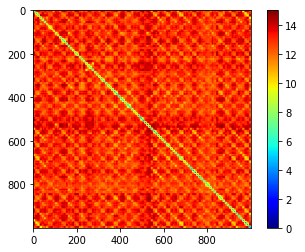

In [118]:
# global

from matplotlib.pyplot import imshow

debslice = 0
lenslice = 189
sl = slice(debslice, lenslice) 
sliced_feat = catglobal_feat[sl, ...].reshape(lenslice*Stest*Ktest, num_latentdims)
dist = euclidean_dist(sliced_feat, sliced_feat) 


plt.figure(2)
t = 5
#Visualisation de la matrice des distances entre N et N+v:
tierce = 0
N = tierce*60
v = 1000
imshow((dist)[N:N+v,N:N+v], vmin=0, vmax=15, cmap='jet')
plt.colorbar()

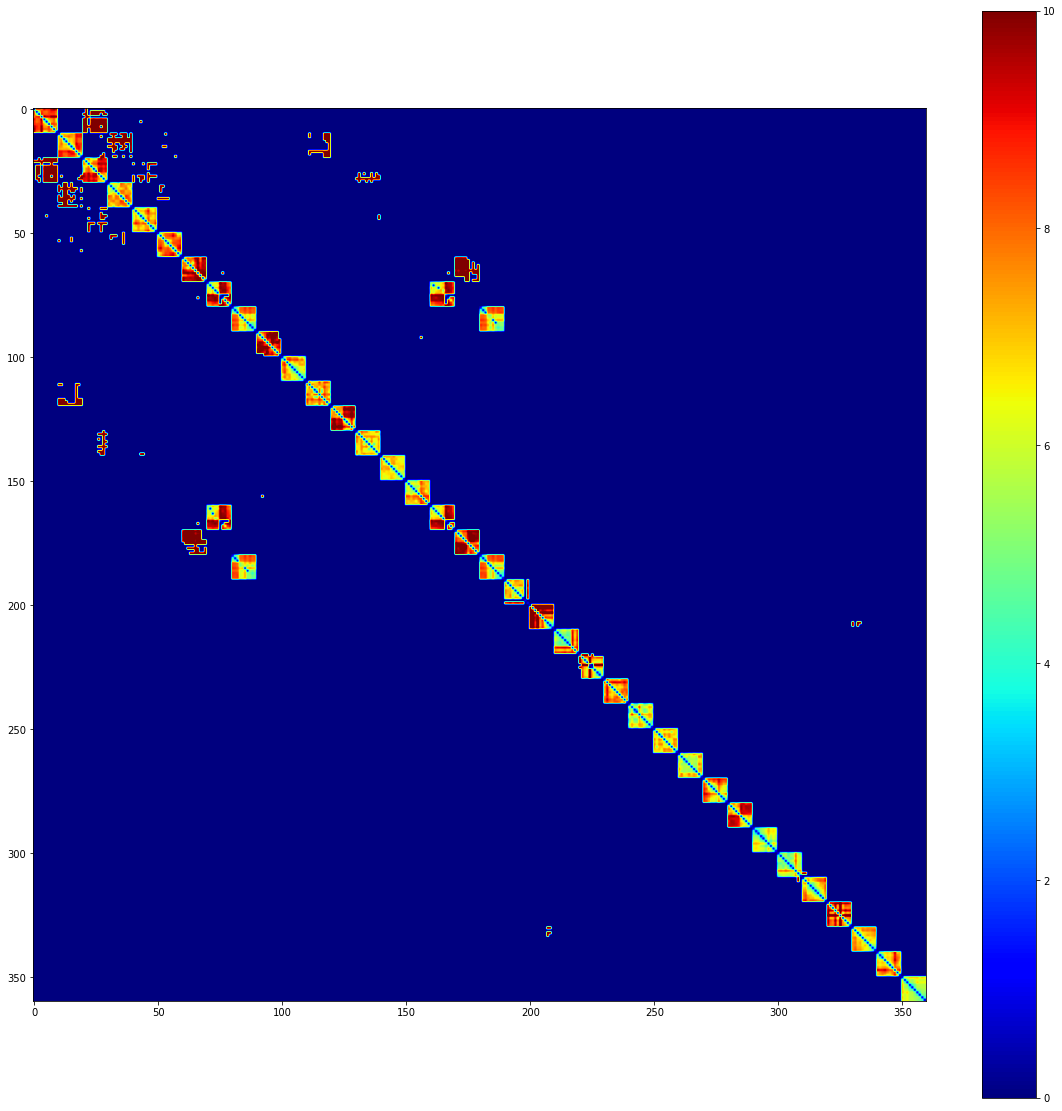

In [119]:
# scène à scène
from matplotlib.pyplot import imshow
s = 0
debslice = 0
lenslice = 189
sl = slice(debslice, lenslice) 
sliced_feat = catglobal_feat[sl, s, ...].reshape(lenslice*Ktest, num_latentdims)
dist = euclidean_dist(sliced_feat, sliced_feat) 



# debslice = 0
# lenslice = 189
# sl = slice(debslice, lenslice) 
# sliced_feat = catglobal_feat[sl, ...].reshape(lenslice*Ktest*Stest, num_latentdims)
# dist = euclidean_dist(sliced_feat, sliced_feat) 


plt.figure(2, figsize=(20,20))
t = 10.
#Visualisation de la matrice des distances entre N et N+v:

N = 0
v = ds_size * 10
M = dist[N:N+v,N:N+v]
M = dist[500:860,500:860]
# M = dist[200:220,1420:1440]
# imshow(M, vmin=0, vmax=10, cmap='jet')
imshow(M *(M<t).float() + (M<=t).float(), vmin=0, vmax=10, cmap='jet')
plt.colorbar()
labels = catglobal_labels.view(ds_size, Stest, Ktest)
labels = labels[:, s, :]
# print((labels[sl, :].reshape(-1))[N:(N+v)]//10)

**E.5** Cas de confusion:

scène 20 - 142
scène 21 - 143
scène 50 - 52
57 - 66
58 - 68
69 - 85

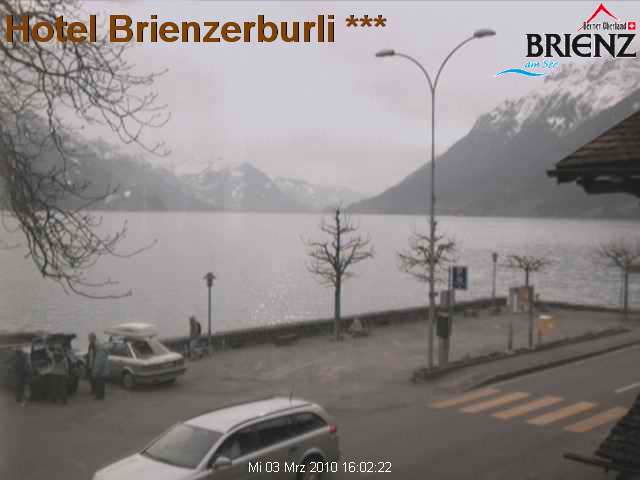

In [85]:
rep1 = join(dir_test, sorted(ls(dir_test))[20])
rep2 = join(dir_test, sorted(ls(dir_test))[142])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img



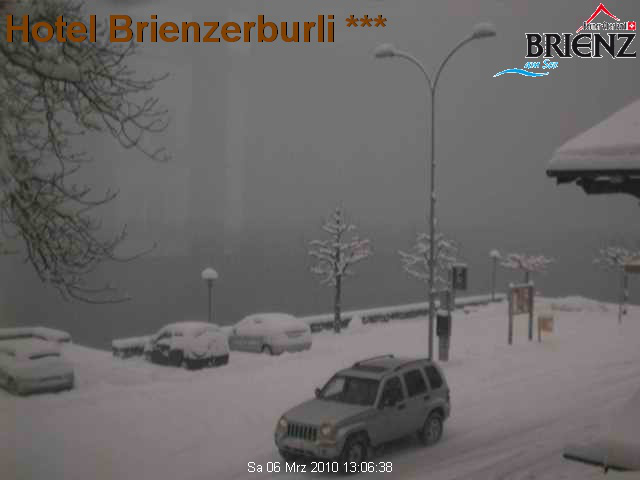

In [86]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

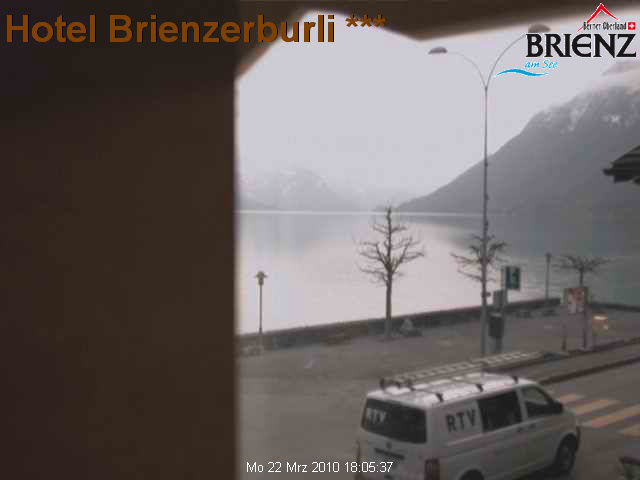

In [87]:
rep1 = join(dir_test, sorted(ls(dir_test))[21])
rep2 = join(dir_test, sorted(ls(dir_test))[143])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

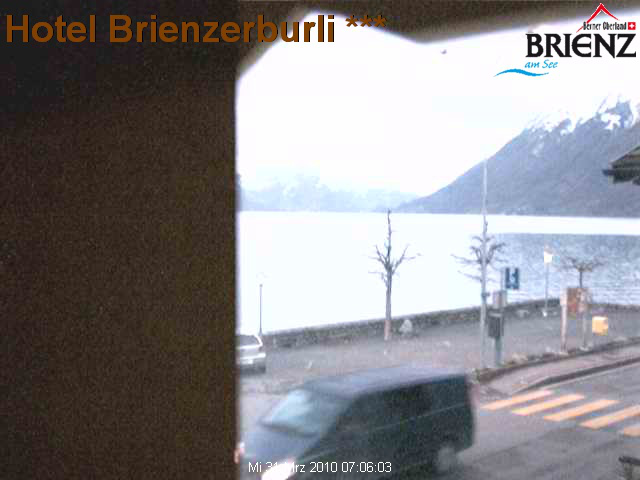

In [88]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

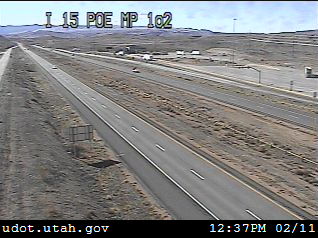

In [89]:
rep1 = join(dir_test, sorted(ls(dir_test))[50])
rep2 = join(dir_test, sorted(ls(dir_test))[52])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

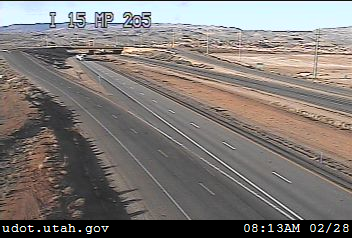

In [90]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

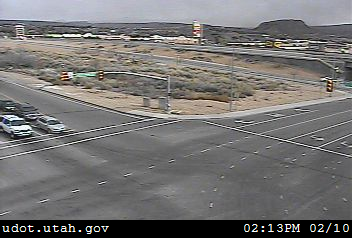

In [91]:
rep1 = join(dir_test, sorted(ls(dir_test))[57])
rep2 = join(dir_test, sorted(ls(dir_test))[66])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

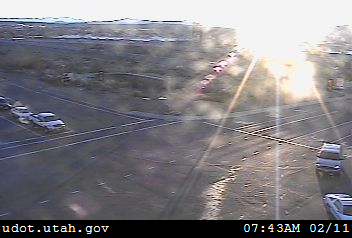

In [92]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

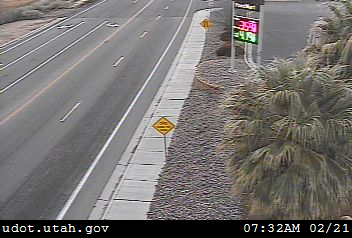

In [93]:
rep1 = join(dir_test, sorted(ls(dir_test))[58])
rep2 = join(dir_test, sorted(ls(dir_test))[68])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

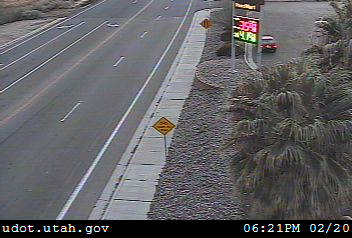

In [94]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

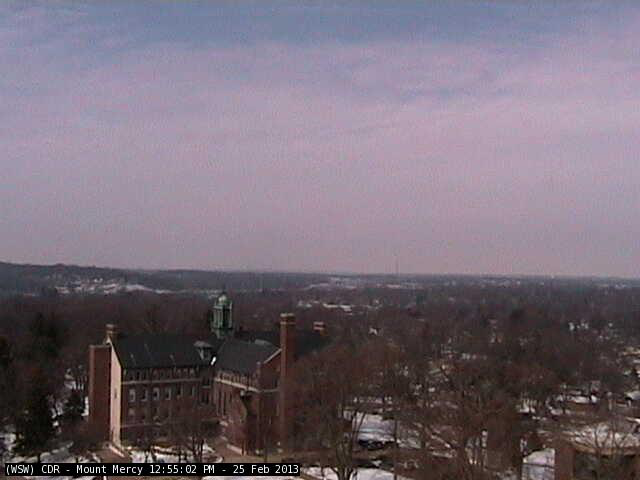

In [95]:
rep1 = join(dir_test, sorted(ls(dir_test))[69])
rep2 = join(dir_test, sorted(ls(dir_test))[85])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

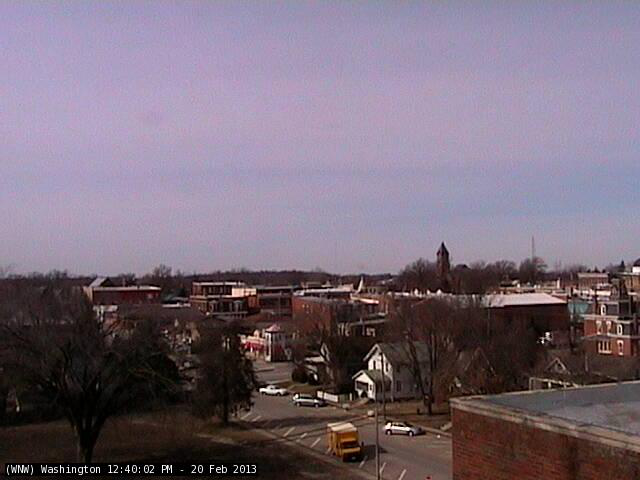

In [96]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

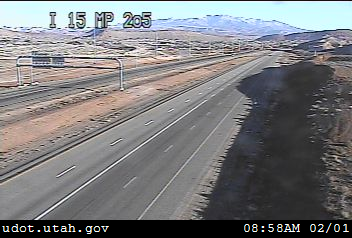

In [97]:
# pour resnet50_nl: pas l'erreur précédente, mais: 51 61:
rep1 = join(dir_test, sorted(ls(dir_test))[51])
rep2 = join(dir_test, sorted(ls(dir_test))[61])

img_path = join(rep1, ls(rep1)[0])
img = Image.open(img_path)
img

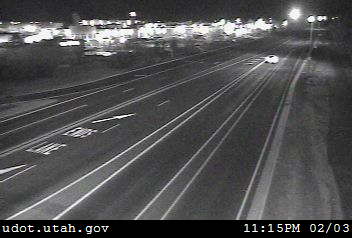

In [98]:
img_path = join(rep2, ls(rep2)[0])
img = Image.open(img_path)
img

In [99]:
# Annexe : si pas metric learning:

# Instance of transforms:
size_in = 256+32
size_out = 64
tr_test = tr_ReID_test(size_in, size_out)


# Instance of Dataset_ReID
Ktest_viz = 4
Ktest = 10
Stest = 6
batch_size_test = 3

Ntest = batch_size_test * Stest

kwargs_test = {'size_in': size_in,
                'size_out': size_out,
                'marginsup':0.1,
                'margininf':0.1,
                'cropped_prop':0.7,
                'zoom':0
                }




ds_test = Dataset_ReID_test(dir_test, tr_test, Ktest, Stest, **kwargs_test) 
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size_test, 
                                           shuffle=False, num_workers=2)

In [100]:
global_feat = []
global_labels = []
with torch.no_grad():
    for i, (images, labels, _)  in enumerate(dl_test):
        if i>=10:
          break
        bs, bSK, ch, size, _ = images.shape
        bN = bs * bSK // Ktest 
        feat = (images.view(bs * Ktest, Stest, ch * size * size))[:,0,:]

        global_feat.append(feat)
        del images
        del feat
        torch.cuda.empty_cache()            

catglobal_feat = torch.cat(global_feat, dim=0) 




In [101]:
catglobal_feat.shape 

torch.Size([300, 12288])

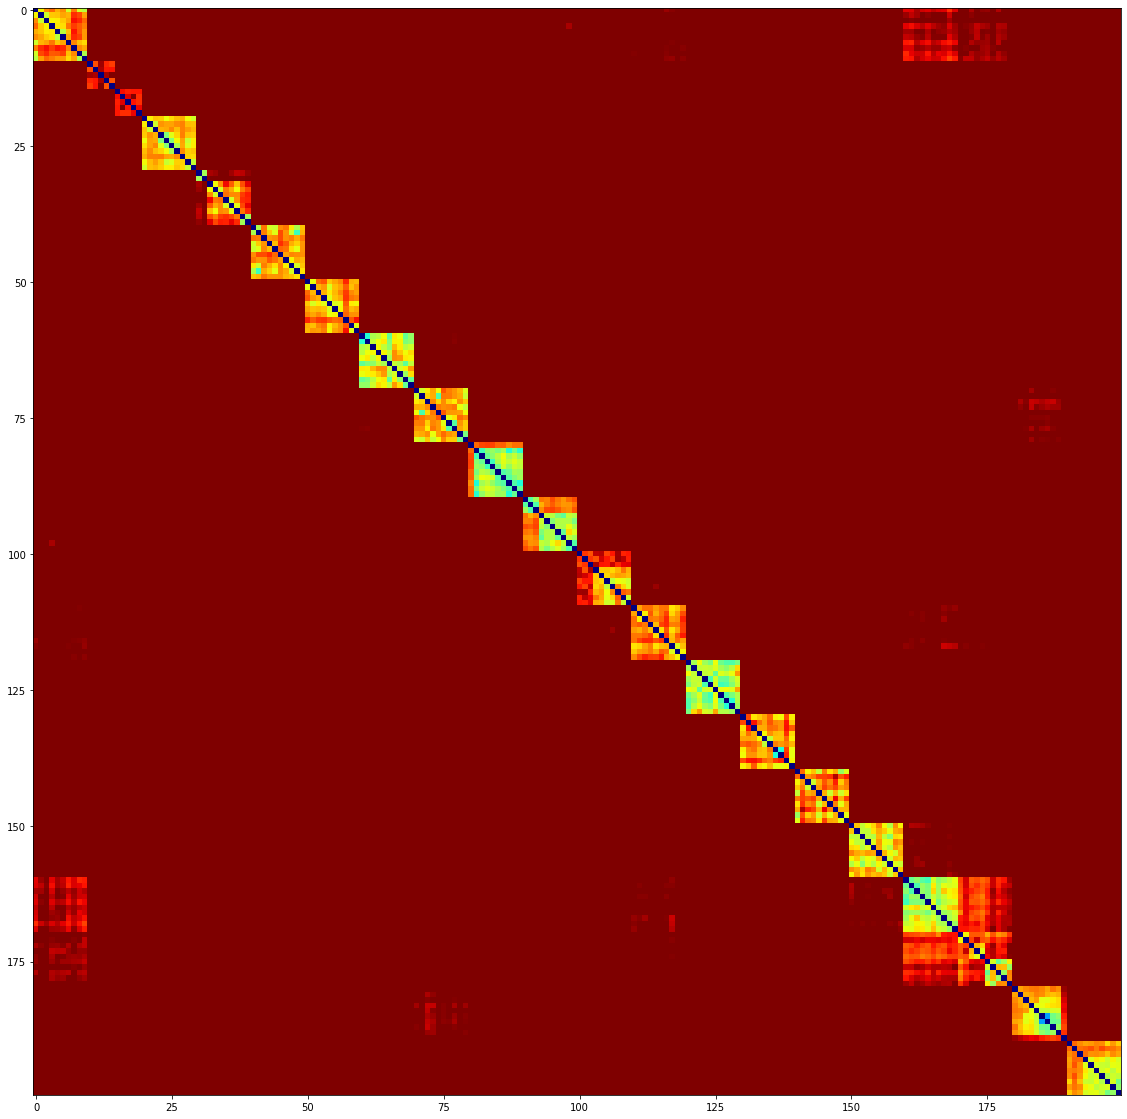

In [102]:
plt.figure(2, figsize=(20,20))
t = 4.
#Visualisation de la matrice des distances entre N et N+v:

N = 0
v = ds_size * 10

M = dist[0:200,0:200]
# M = dist[200:220,1420:1440]
imshow(M, vmin=0, vmax=10, cmap='jet')
# imshow(M *(M<t).float() + (M<=t).float(), vmin=0, vmax=10, cmap='jet')


In [103]:
def distL1s2(x, y):
    """
    Args:
      x: pytorch Variable, with shape [m, d]
      y: pytorch Variable, with shape [n, d]
    Returns:
      dist: pytorch Variable, with shape [m, n]
    """
    p = 2
    m, d = x.shape
    n, dy = y.shape
    assert d == dy  
    xx = x.view(m,1,d).expand(m, n, d)
    yy = y.view(1,n,d).expand(m, n, d)
    dist = (torch.abs(xx-yy)**p).sum(dim=2).clamp(min=1e-12)**(1/p)
#    dist.addmm_(1, -2, x, y.t())
#    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

In [104]:
N = 0
v = ds_size * 10
raw_dist = distL1s2(catglobal_feat, catglobal_feat)



In [105]:
raw_dist[0:200,0:200].mean()

tensor(119.1851)

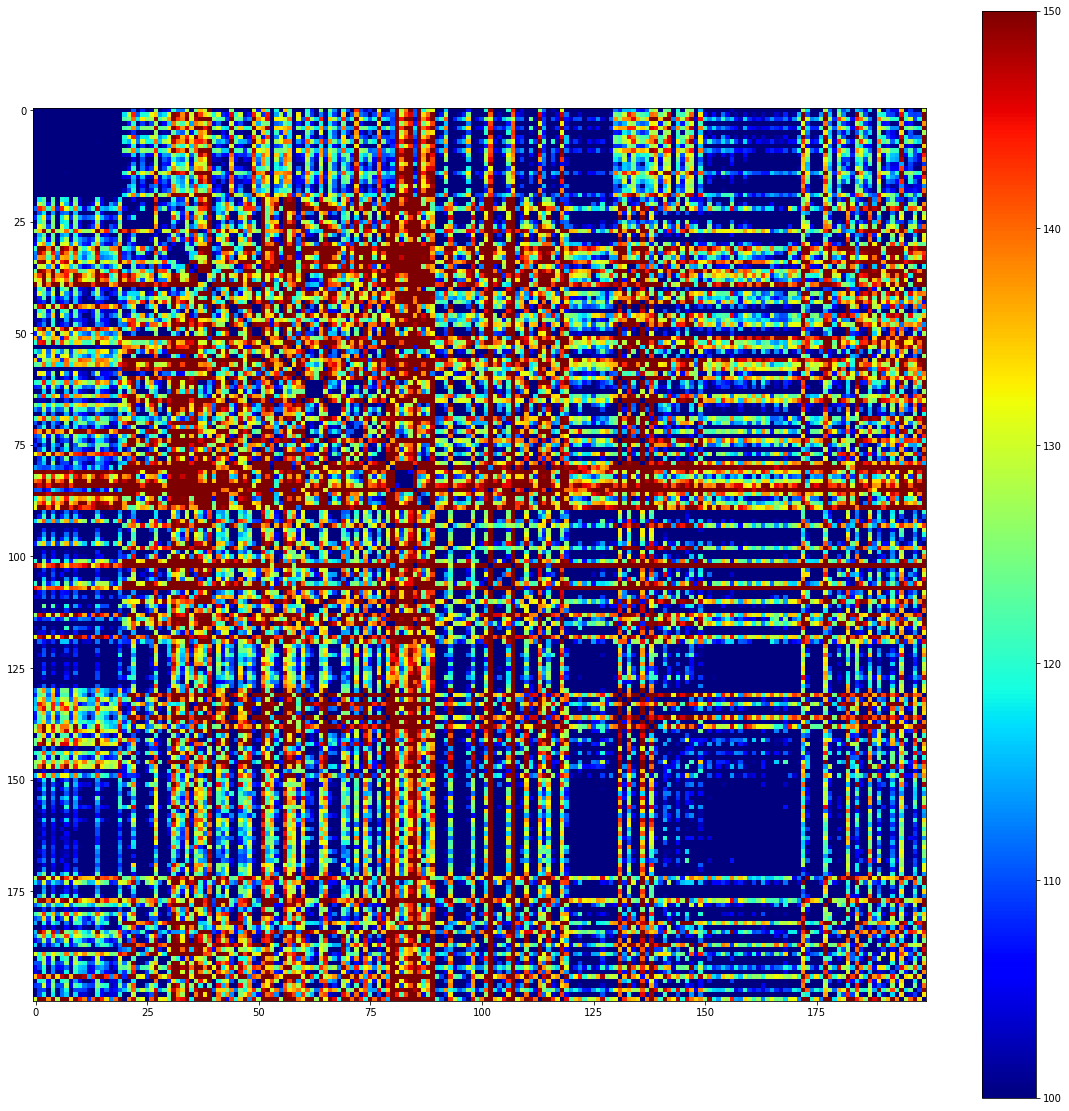

In [106]:
plt.figure(2, figsize=(20,20))
M = raw_dist[0:200,0:200]
# M = dist[200:220,1420:1440]
imshow(M, vmin=100, vmax=150, cmap='jet')
plt.colorbar()
# imshow(M *(M<t).float() + (M<=t).float(), vmin=0, vmax=10, cmap='jet')